In [1]:
import sys
import pathlib
import time

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import cm

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
# Local
cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))
sys.path.append(str(root))

from utils.watertopo import WaterTopo
from utils.simulation import Simulation
from utils.utils import count_parameters, create_sequence, recursive_pred, mse_per_timestep
from utils.train import train_and_validate, evaluate_model, train

In [3]:
#initialize GPU -  In case of windows use cuda instead of nps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA enabled?",torch.cuda.is_available())
print("Number of GPUs",torch.cuda.device_count())

Is CUDA enabled? True
Number of GPUs 1


In [4]:
class BasicCNN(nn.Module):
    def __init__(self, 
                 input_channels,
                 hidden_size,
                 output_channels=1,
                 bias=True,
                 kernel_size=(3, 3, 3, 3), 
                 pool_kernel_size=1,
                 pool_stride=1, 
                 nonlinearity=F.relu
                 ):
        super(BasicCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, hidden_size, kernel_size=kernel_size[0], padding=1, bias=bias)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size[1], padding=1, bias=bias)
        self.conv3 = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size[2], padding=1, bias=bias)
        self.conv4 = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size[3], padding=1, bias=bias)

        # Batch normalization layers
        self.batchnorm1 = nn.BatchNorm2d(num_features=hidden_size)
        self.batchnorm2 = nn.BatchNorm2d(num_features=hidden_size)
        self.batchnorm3 = nn.BatchNorm2d(num_features=hidden_size)
        self.batchnorm4 = nn.BatchNorm2d(num_features=hidden_size)

        # Pooling has no learnable parameters, so we can just use one
        self.pool = nn.AvgPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        # Definition of nonlinearity function
        self.nonlinearity=nonlinearity

        # Last layer
        self.fc = nn.Conv2d(hidden_size, output_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        # Convolutions
        # print("input: ", x.size())
        x = self.pool(self.nonlinearity(self.batchnorm1(self.conv1(x))))
        x = self.pool(self.nonlinearity(self.batchnorm2(self.conv2(x))))
        x = self.pool(self.nonlinearity(self.batchnorm3(self.conv3(x))))
        x = self.pool(self.nonlinearity(self.batchnorm4(self.conv4(x))))
        # print("after 4 convolution: ", x.size())

        # Output layer
        x = self.fc(x)
        # print("output: ", x.size())

        return x

In [5]:
model = BasicCNN(input_channels=2,
                 hidden_size=32,
                 output_channels=1,
                 bias=True,
                 kernel_size=(3, 3, 3, 3), 
                 pool_kernel_size=1,
                 pool_stride=1, 
                 nonlinearity=F.relu
                 ).to(device)

print(f"CNN --> num. trainable parameters:{count_parameters(model):8d}")

CNN --> num. trainable parameters:   28641


In [6]:
save_path = "trained_models/CNN_kevin"

model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [7]:
# Let's try the model recursively!
model.eval()

grid_size = 64
channels = 2
sim_length = 97

# Let's do a crude Monte Carlo with a single model, calculating the loss after each timestep
sim = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val/", 1, grid_size)[0]
inputs = np.zeros((1, channels, grid_size, grid_size))
targets = np.zeros((sim_length, grid_size, grid_size))

# Select the time step where you want to start
id = 0

inputs[0, 0, :, :] = sim.topography
inputs[0, 1, :, :] = sim.return_timestep(id)
inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
inputs.cpu()

for t in range(1, sim_length):
   targets[t-1,:,:] = sim.return_timestep(t)

targets = torch.tensor(targets, dtype=torch.float32)
targets[0,:,:] = inputs[0,1,:,:]

outputs = torch.zeros(targets.shape).cpu()
outputs[0,:,:] = inputs[0,1,:,:]

print(inputs.shape)
print(targets.shape)
print(outputs.shape)

for t in range(1, sim_length):
   outputs[t,:,:] = model(inputs)
   inputs[0,1,:,:] = outputs[t,:,:]

mse = mse_per_timestep(targets, outputs)

torch.Size([1, 2, 64, 64])
torch.Size([97, 64, 64])
torch.Size([97, 64, 64])


Text(0.5, 1.0, 'CNN - MSE per timestep')

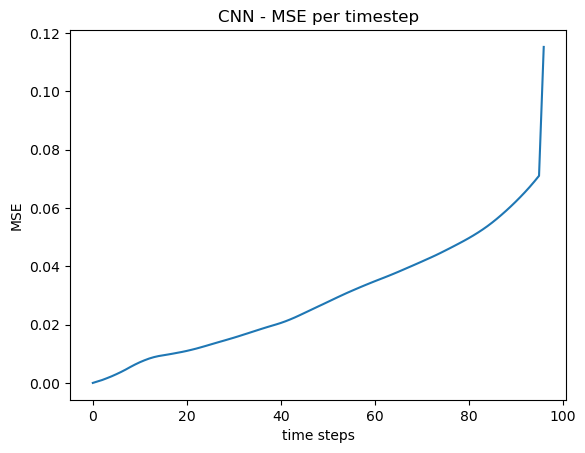

In [8]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, len(mse)), mse, label="MSE")
ax.set_xlabel("time steps")
ax.set_ylabel("MSE")
ax.set_title("CNN - MSE per timestep")

In [69]:
coords = np.arange(0.5, 64, 1) * 100

X = np.zeros((64, 64))
Y = np.zeros((64, 64))

for i in range(0, 64):
    X[:,i] = coords
    Y[i,:] = coords

topo = inputs[0,0,:,:].cpu()
wd = outputs.cpu()

topo = np.array(topo.detach().numpy())
wd = np.array(wd.detach().numpy())

water_level = np.array((topo + wd).detach().numpy())

# mask = np.zeros(wd.shape)

# water_level[wd<0.1] = np.nan

# print(np.sum(np.isnan(water_level)))
# print(np.mean(water_level))
# print(np.sum((wd==0))+np.sum((wd!=0)))
# print(97*64*64)
# print(np.sum(wd<0.1))
# print(X)
# print(Y)
# print(WL.shape)
# print(wd.shape)
# print(np.std(topo))
# print(np.std(wd[96]))

# Where is the water coming from?
for nx, ny in ((0,0),(63,0),(0,63),(63,63)):
    if wd[0, nx, ny] != 0:
        print(f'Water is coming from (nx,ny) = ({nx}, {ny}), i.e. (x,y) = ({nx*100+50}, {ny*100+50})')
        break

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

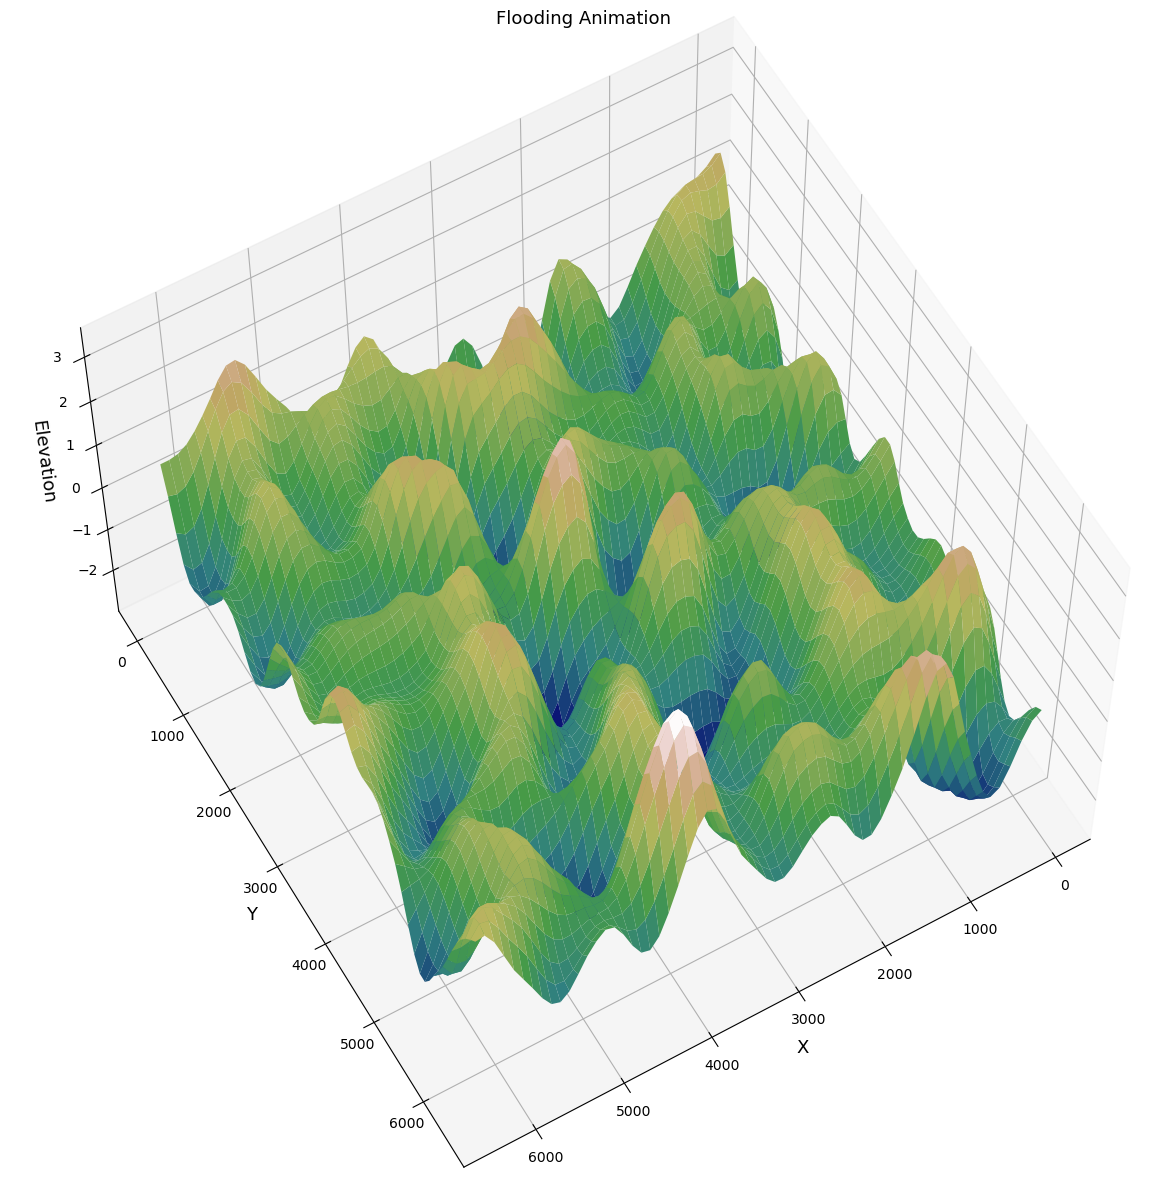

In [70]:
# %matplotlib notebook

fps = 250
frn = len(water_level)

def change_plot(frame_number, newh, plot):
   plot[0].remove()
   plot[0] = ax.plot_surface(X, Y, newh[frame_number,:,:], rstride=1, cstride=1, cmap = 'Blues',linewidth=0, vmin=np.min(newh), vmax=np.max(newh))

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

plot = [ax.plot_surface(X, Y, topo, rstride=1, cstride=1,cmap =  cm.gist_earth, linewidth=0, edgecolor='none',alpha = 1)]
plot = [ax.plot_surface(X, Y, water_level[0], rstride=1, cstride=1, cmap = 'Blues',linewidth=0, vmin=np.min(water_level), vmax=np.max(water_level))]

ax.set_title('surface')
ax.view_init(60, 60)

# Set the Title, labels, and fontsize

ax.set_title('Flooding Animation')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Elevation')
ax.xaxis.get_label().set_fontsize(13)
ax.yaxis.get_label().set_fontsize(13)
ax.zaxis.get_label().set_fontsize(13)
ax.title.set_fontsize(13)


# converts the values of any array to RGB colors defined by a colormap
m = cm.ScalarMappable(cmap='Blues')
m.set_array(water_level[0])
# plt.colorbar(m,fraction=0.03)

animation = FuncAnimation(fig, change_plot, frn, fargs=(water_level, plot), interval=1)

# plt.show()

f = "CNN_kevin_target.gif"
writergif = PillowWriter(fps=10)
animation.save(f, writer=writergif)